In [ ]:
#Attach libraries
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import statsmodels.api as sm
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from sklearn import tree

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Mount drive for access to file
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### **Data preparation**

In [ ]:
#Read file
df = pd.read_csv('/content/drive/MyDrive/ALY6040.80439 Group assignment/loan_data.csv.xls')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [ ]:
df = pd.get_dummies(df, columns=['purpose'], drop_first=False, dummy_na=False)
df

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1,1,0,0,0,0,0,0
9574,0,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1,1,0,0,0,0,0,0
9575,0,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1,0,0,1,0,0,0,0
9576,0,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1,0,0,0,0,1,0,0


In [ ]:
# create a new binary variable from int.rate with 1 representing interest rate higher than 14.07%(3rd quartile) and 0 representing interest lower than 14.07%
df["high interest rate"] = df['int.rate']
tmp_condition = df['high interest rate'] >= 0.1407
df.loc[tmp_condition, 'high interest rate'] = 1
df.loc[~tmp_condition, 'high interest rate'] = 0
df['high interest rate'] = pd.to_numeric(df['high interest rate'], downcast='integer', errors='coerce')

### **logistic model**

In [ ]:
from sklearn.model_selection import train_test_split

df
#Split
#x_train, x_test, z_train, z_test = train_test_split(x, z, test_size=0.30)
x = df[['fico','installment','credit.policy','inq.last.6mths','delinq.2yrs','not.fully.paid','purpose_debt_consolidation',
       'purpose_small_business','purpose_all_other','pub.rec','purpose_major_purchase','purpose_home_improvement']]
Y = df[['high interest rate']]

x_train, x_test, z_train, z_test = train_test_split(x, Y, test_size=0.30,random_state=1)

In [ ]:
import statsmodels.api as sm

Xlog2 = sm.add_constant(x_train) 
logr_model = sm.Logit(z_train, Xlog2) 

logr_fit = logr_model.fit()
print(logr_fit.summary())

Optimization terminated successfully.
         Current function value: 0.342016
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:     high interest rate   No. Observations:                 6704
Model:                          Logit   Df Residuals:                     6691
Method:                           MLE   Df Model:                           12
Date:                Mon, 09 May 2022   Pseudo R-squ.:                  0.3946
Time:                        03:04:06   Log-Likelihood:                -2292.9
converged:                       True   LL-Null:                       -3787.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         44.4460      1.367     32.507      0.000      

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

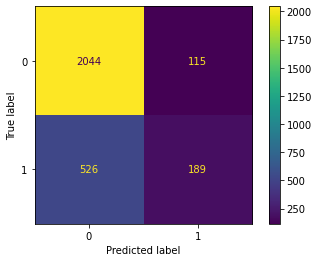

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# Record the time needed to run the code
import time
start = time.process_time()
# Run model
logistic_regression= LogisticRegression()
model=logistic_regression.fit(x_train,z_train)

#view results from confusion matrix
model.fit(x_train, z_train)
plot_confusion_matrix(logistic_regression, x_test, z_test)  
plt.show()

In [ ]:
# Accuracy of logistic regression
# Accuracy
acurracy = round(model.score(x_test,z_test),4)
acurracy


0.777

### **Decision tree model**

In [ ]:
class_names = ['high interest rate','low/average interest rate']
df['high interest rate'] = df['high interest rate'].map({1: class_names[0],
                                0: class_names[1]})

In [ ]:
feature_cols = ['fico','installment','credit.policy','inq.last.6mths','delinq.2yrs','not.fully.paid','purpose_debt_consolidation',
       'purpose_small_business','purpose_all_other','pub.rec','purpose_major_purchase','purpose_home_improvement']
X = df[feature_cols] # Features
y = df[['high interest rate']] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=4)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.8531663187195546


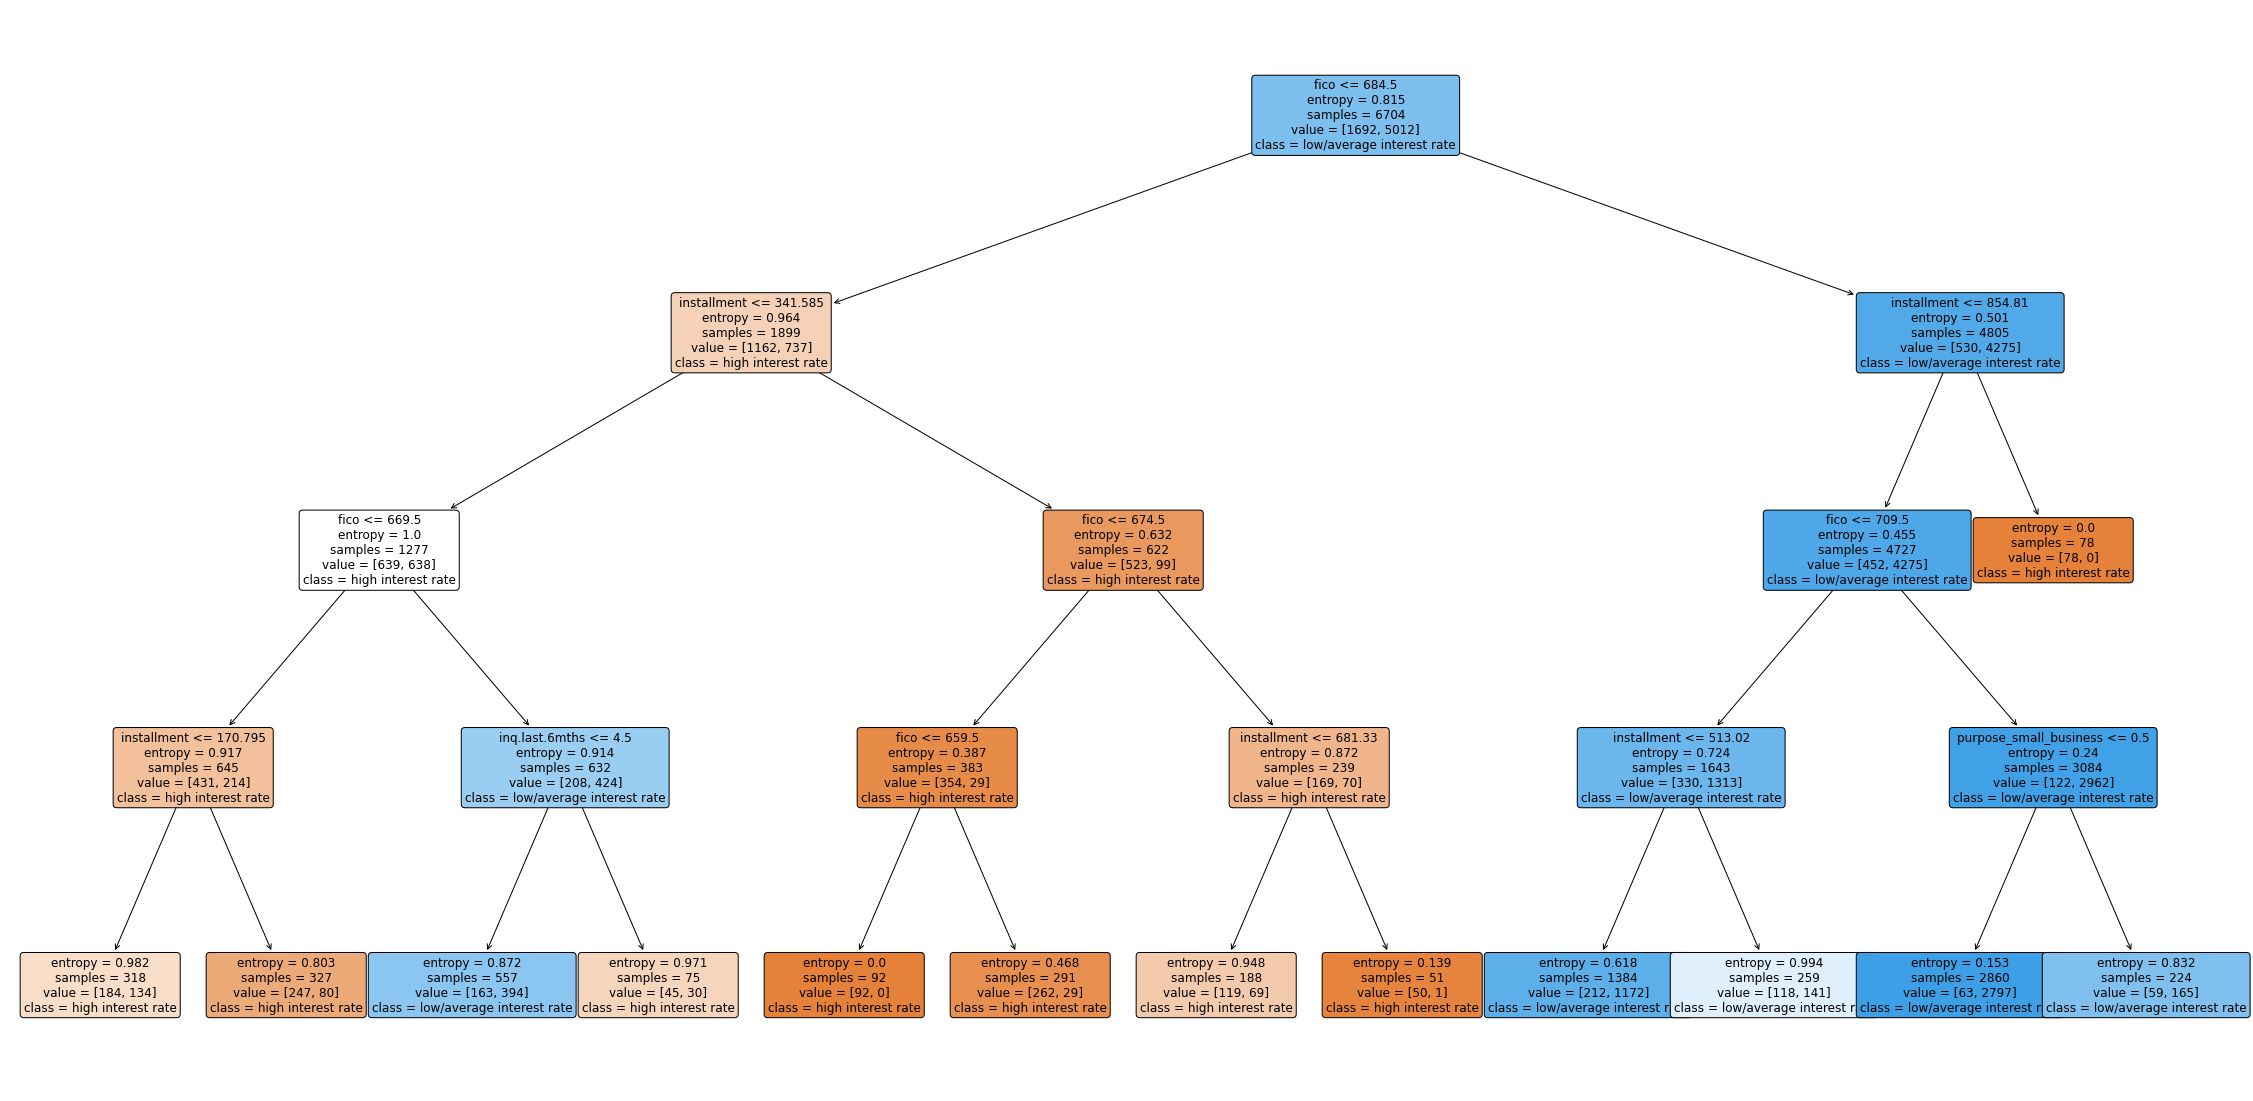

In [ ]:
from sklearn import tree # for decision tree models
plt.figure(figsize = (40,20))
tree.plot_tree(clf, fontsize = 12,rounded = True , filled = True,feature_names = feature_cols,class_names=class_names);

In [ ]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
importances

,feature,importance
0,fico,0.706
1,installment,0.234
7,purpose_small_business,0.052
3,inq.last.6mths,0.008
2,credit.policy,0.000
4,delinq.2yrs,0.000
5,not.fully.paid,0.000
6,purpose_debt_consolidation,0.000
8,purpose_all_other,0.000
9,pub.rec,0.000


### **Random Forest Model**

In [ ]:
X = df[feature_cols] # Features
y = df[['high interest rate']] # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [ ]:
# Instantiate and fit the RandomForestClassifier
forest = RandomForestClassifier(n_estimators=5000, max_depth=4)
forest.fit(X_train, y_train)


y_pred_test = forest.predict(X_test)


print("Accuracy:",accuracy_score(y_test, y_pred_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy: 0.8469032707028532


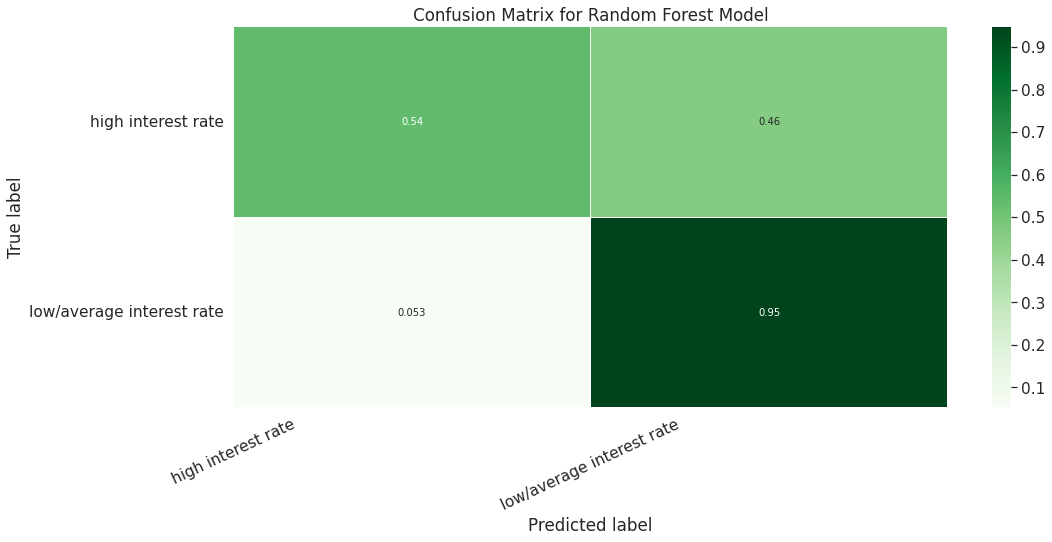

In [ ]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


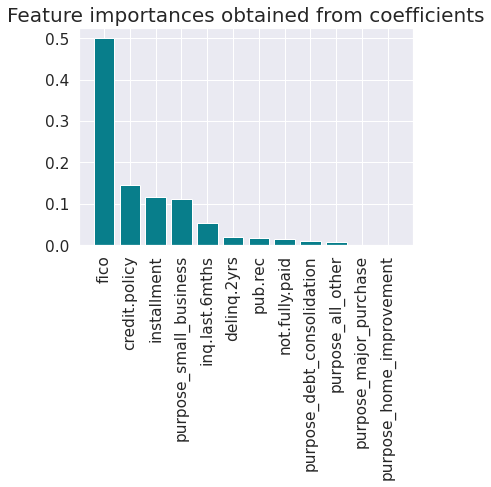

In [ ]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

Gradient Boosting Classifier

In [ ]:
# Importing the dataset
from google.colab import files
file = files.upload()
df = pd.read_csv('loan.csv')


Saving loan.csv to loan (1).csv


In [ ]:
# split Train Test set
X = df[feature_cols] # Features
y = df[['high interest rate']] # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [ ]:
# Create Gradient Boosting Model
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
GBT = GradientBoostingClassifier(random_state=1,n_estimators=200).fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


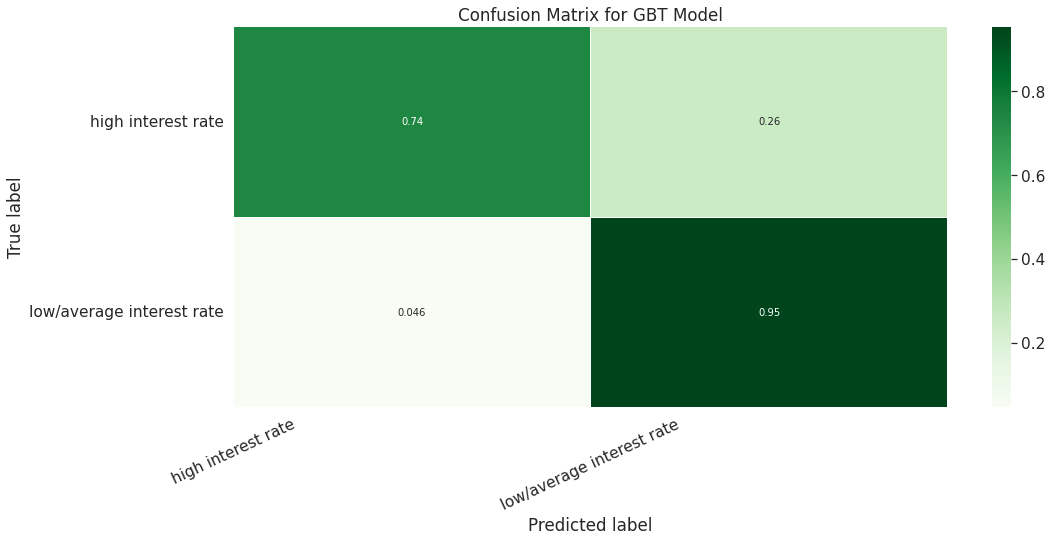

In [ ]:
from sklearn.metrics import confusion_matrix
GBT_matrix = confusion_matrix(y_test, GBT.predict(X_test))
GBT_matrix = GBT_matrix.astype('float') / GBT_matrix.sum(axis=1)[:, np.newaxis]
# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(GBT_matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for GBT Model')
plt.show()

# As the confusion matrix plot shows, it delightly to know the Specificity rate(interest class = 'high interest rate') is 95%. However our Sensitivity is 74%, it might because of our inbalanced train data.

In [ ]:
# calculate accuracy of GBT
print("Accuracy: %.2f%%" % (accuracy_score(y_test, GBT.predict(X_test)) * 100.0))

Accuracy: 90.08%


In [ ]:
GBT.feature_importances_

importances_GBT = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': GBT.feature_importances_
})
importances_GBT = importances_GBT.sort_values(by='Importance', ascending=False)
importances_GBT

,Attribute,Importance
0,fico,0.569179
1,installment,0.347286
7,purpose_small_business,0.042724
3,inq.last.6mths,0.028861
2,credit.policy,0.006554
4,delinq.2yrs,0.001312
10,purpose_major_purchase,0.001118
8,purpose_all_other,0.000988
5,not.fully.paid,0.000865
9,pub.rec,0.000617


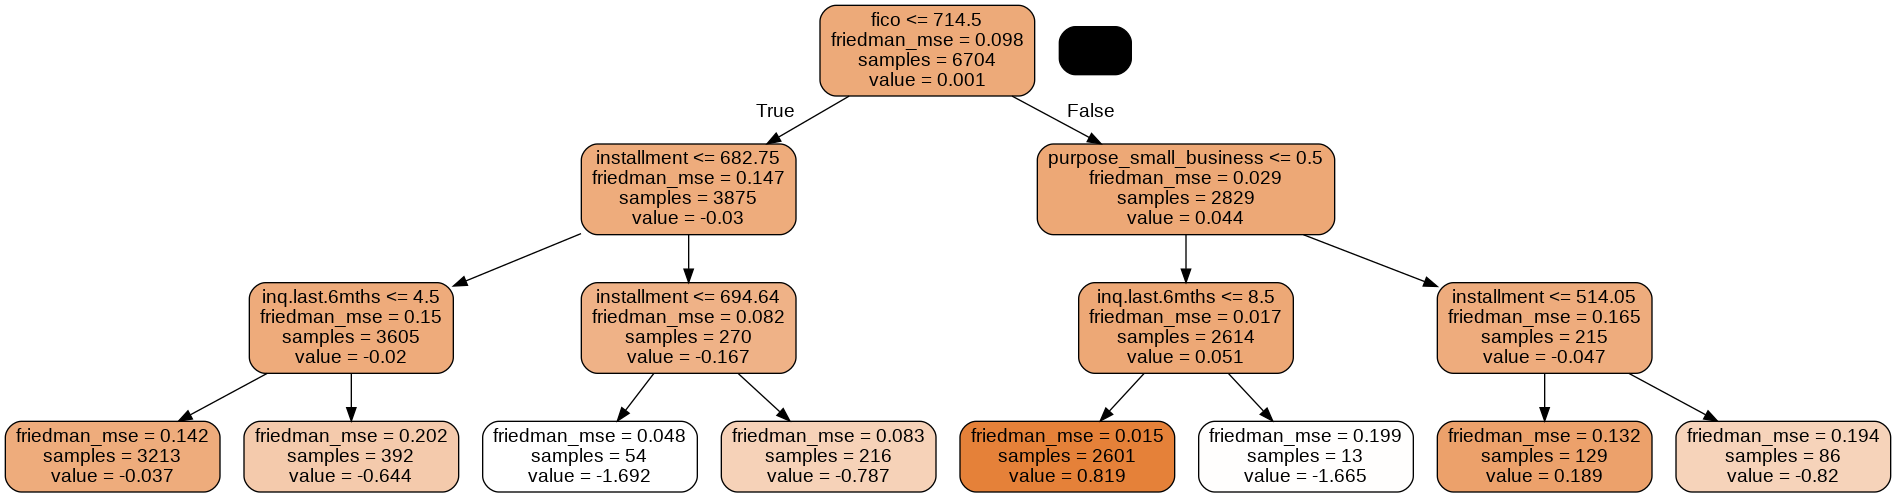

In [ ]:
from pydotplus import graph_from_dot_data
from IPython.display import Image
# Because we have 200 estimators, so its not practical to show all of them. In this plot we only show decision of #20 tree 
# get #20 tree
sub_tree_20 = GBT.estimators_[20, 0]
# plot #20 tree
dot_data = export_graphviz(
    sub_tree_20,
    feature_names = feature_cols,
    class_names = class_names,
    rounded = True , filled = True
)
graph = graph_from_dot_data(dot_data)
Image(graph.create_png())
# Because GBT model is not making final class decision until all estimator give feed backs, class label is meaningless for single estimator 

In [ ]:
class_names

['high interest rate', 'low/average interest rate']